# Co-rotating vortices

In [1]:
using ViscousFlow

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/ViscousFlow/2kdbn.ji for ViscousFlow [103da179-b3e4-57c1-99a4-586354eb2c5a]
└ @ Base loading.jl:1240


In [2]:
using Plots
pyplot()
default(grid = false)

### Set up a grid and a Reynolds number

In [3]:
xlim = (-2,2); ylim = (-2,2)
Δx = 0.02
Re = 200

200

In [4]:
Δt = min(0.5*Δx,0.5*Δx^2*Re)

0.01

In [5]:
sys = NavierStokes(Re,Δx,xlim,ylim,Δt)

Navier-Stokes system on a grid of size 208 x 208

In [6]:
w₀ = Nodes(Dual,size(sys));

In [7]:
xg,yg = coordinates(w₀,dx=Δx,I0=origin(sys))

(-2.07:0.02:2.07, -2.07:0.02:2.07)

### Make a Gaussian patch function

In [8]:
using LinearAlgebra
gaussian(x,x0,σ) = exp(-LinearAlgebra.norm(x.-x0)^2/σ^2)/(π*σ^2)

gaussian (generic function with 1 method)

### Set up the integrator

#### First set up the integrating factor plan

In [9]:
plan_intfact(t,w) = CartesianGrids.plan_intfact(t,w,sys)

plan_intfact (generic function with 1 method)

#### The right-hand side function

In [10]:
r₁(w,t) = ConstrainedSystems.r₁(w,t,sys)

r₁ (generic function with 1 method)

#### And finally, the integrator

In [11]:
solver = IFRK(w₀,sys.Δt,plan_intfact,r₁,rk=ConstrainedSystems.RK31)

Order-3 IF-RK integator with
   State of type Nodes{Dual,208,208,Float64,Array{Float64,2}}
   Time step size 0.01


### Now solve the problem

In [12]:
t = 0.0
x01 = (-0.5,0); x02 = (0.5,0); σ = 0.2; Γ = 1
w₀ .= [Γ*gaussian((x,y),x01,σ) + Γ*gaussian((x,y),x02,σ) for x in xg, y in yg]*Δx
w = deepcopy(w₀);

In [13]:
tf = 5
T = 0:Δt:tf;

In [14]:
@time for ti in T
    global t, w = solver(t,w)
end

 43.700683 seconds (777.10 M allocations: 31.400 GiB, 9.44% gc time)


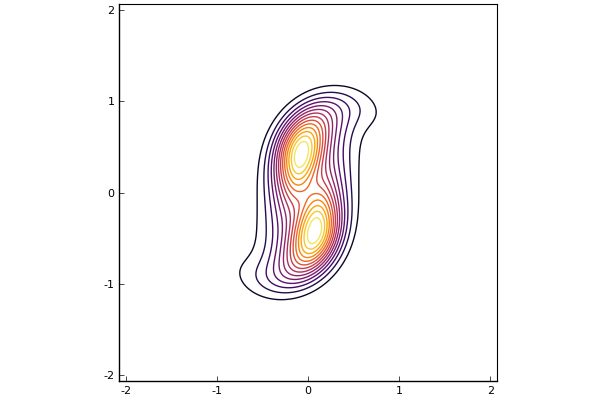

In [15]:
plot(xg,yg,w)